In [1]:
import pickle
import matplotlib.pyplot as plt
from hts import HTSRegressor
from hts.hierarchy import HierarchyTree
from m5 import *
import time


import warnings
warnings.filterwarnings("ignore")

## Auxiliar Function

In [2]:
# Function to reduce memory to increase performance to decrease run time.
def downcasting(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
def runModel(modelName, hierarchy, dataFrame, revisionMethod=None):
    
    clf = HTSRegressor(model=modelName, revision_method=revisionMethod, n_jobs=4)
    return clf.fit(dataFrame, hierarchy)

In [4]:
def prediction(model, steps=28):
    return model.predict(steps_ahead=steps)

In [5]:
def saveModel(path, model, method, ols, samples=None):
    
    dt = time.localtime()
    strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
    dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

    if (samples):
        filename = path + "model" + method + ols + str(samples) + strinstante + ".pkl"
    else:
        filename = path + "model" + method + ols + strinstante + ".pkl"
        
    with open(filename, 'wb') as file:
        pickle.dump(model, file, protocol=4)

In [6]:
def loadModel(path):
        
    with open(path, 'rb') as file:
        model = pickle.load(file)
        
    return model

In [7]:
def saveDataset(path, dataFrame, method, ols, samples=None):
    
    dt = time.localtime()
    strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
    dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

    if (samples):
        filename = path + "dataset" + method + ols + str(samples) + strinstante + ".pkl"
    else:
        filename = path + "dataset" + method + ols + strinstante + ".pkl"
        
    dataFrame.to_pickle(filename)

In [8]:
def plot(dictPlot, predictions, dataFrame):
    
    fig, axs = plt.subplots(len(dictPlot), figsize=(20, 30), sharex=True)
    # ax.grid(alpha=0.75)
    PLOT_FROM = 0
    dts = predictions[PLOT_FROM:].index

    for i, group in enumerate(dictPlot):
        axs[i].plot(dataFrame[PLOT_FROM:][group], 
                lw=1.1, 
                color='#2ecc71', 
                alpha=0.8, 
                label='Truth')
        axs[i].plot(predictions[PLOT_FROM:][group], 
                lw=1.1,
                color='#e74c3c', 
                alpha=0.8, 
                label='Prediction')
        axs[i].grid(alpha=0.75)
        axs[i].legend()
        axs[i].set_title(group)

In [9]:
def dataRangeSelection(df, start_date, end_date):
    #start_date = '2012-04-24'
    #end_date = '2016-04-24'
    mask = (df.index >= start_date) & (df.index <= end_date)    
    return df.loc[mask]

In [10]:
def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error

    results = {}
    for column in y_true.columns:
        results[column] = mean_squared_error(y_true[column], 
                                             y_pred[column], 
                                             squared=False)
    
    return pd.Series(results)

In [11]:
def mape(y_true, y_pred):
    from sklearn.metrics import mean_absolute_percentage_error

    results = {}
    for column in y_true.columns:
        results[column] = mean_absolute_percentage_error(y_true[column], 
                                                         y_pred[column])
    
    return pd.Series(results)

In [12]:
def mase(y_true, y_pred, y_train):
    from metrics import mean_absolute_scaled_error

    return mean_absolute_scaled_error(y_true, y_pred, y_train)

## create Hierarchy Tree Front

In [13]:
def createHierarchyTree(self, _last=True):

    ht_tree = {
            'name':  self.key,
        }
    child_count = len(self.children)
    
    for i, child in enumerate(self.children):
        _last = i == (child_count - 1)
        if i == 0:
            ht_tree['children'] = []
            
        ht_tree['children'].append(createHierarchyTree(child, _last=_last))
    return ht_tree

## Run

In [14]:
dataset_path = 'data/'
data_set = M5(dataset_path, samples=50)

data_set.train_set

,CA,WI,TX,CA_4,WI_2,WI_3,TX_2,CA_1,TX_3,TX_1,...,TX_3_FOODS_2_055_TX_3_validation,CA_4_HOUSEHOLD_1_524_CA_4_validation,CA_1_HOBBIES_1_328_CA_1_validation,CA_1_HOBBIES_1_295_CA_1_validation,CA_4_HOBBIES_2_095_CA_4_validation,TX_3_HOBBIES_1_213_TX_3_validation,TX_1_HOBBIES_1_089_TX_1_validation,CA_2_HOBBIES_1_177_CA_2_validation,CA_3_FOODS_1_016_CA_3_validation,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,31,12,9,0,0,6,3,10,2,4,...,0,0,2,0,0,2,0,0,3,52
2011-01-30,72,3,25,0,0,1,14,40,2,9,...,0,0,0,36,0,0,0,0,0,100
2011-01-31,59,8,11,0,0,8,9,39,0,2,...,0,0,1,36,0,0,0,0,0,78
2011-02-01,8,7,16,0,1,4,6,3,0,10,...,0,0,1,0,0,0,0,0,0,31
2011-02-02,24,5,11,0,0,5,2,9,1,8,...,0,0,0,8,0,1,0,0,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,18,13,9,1,0,6,6,5,0,3,...,0,0,1,0,0,0,0,1,0,40
2016-04-21,22,19,18,5,0,9,9,11,2,7,...,0,0,0,7,0,0,1,0,0,59
2016-04-22,23,12,10,2,0,4,4,7,4,2,...,0,1,0,4,0,0,1,1,0,45


## Preprocess Data (Optional)

In [15]:
dfSelected = downcasting(data_set.train_set)

## Json Tree Front

In [16]:
ht = HierarchyTree.from_nodes(nodes=data_set.hierarchy, df=dfSelected)
ht_tree = createHierarchyTree(ht)

ht_tree

{'name': 'total',
 'children': [{'name': 'CA',
   'children': [{'name': 'CA_4',
     'children': [{'name': 'CA_4_FOODS',
       'children': [{'name': 'CA_4_FOODS_3',
         'children': [{'name': 'CA_4_FOODS_3_143_CA_4_validation'}]},
        {'name': 'CA_4_FOODS_2',
         'children': [{'name': 'CA_4_FOODS_2_185_CA_4_validation'}]}]},
      {'name': 'CA_4_HOBBIES',
       'children': [{'name': 'CA_4_HOBBIES_1',
         'children': [{'name': 'CA_4_HOBBIES_1_042_CA_4_validation'},
          {'name': 'CA_4_HOBBIES_1_241_CA_4_validation'}]},
        {'name': 'CA_4_HOBBIES_2',
         'children': [{'name': 'CA_4_HOBBIES_2_076_CA_4_validation'},
          {'name': 'CA_4_HOBBIES_2_095_CA_4_validation'}]}]},
      {'name': 'CA_4_HOUSEHOLD',
       'children': [{'name': 'CA_4_HOUSEHOLD_2',
         'children': [{'name': 'CA_4_HOUSEHOLD_2_412_CA_4_validation'}]},
        {'name': 'CA_4_HOUSEHOLD_1',
         'children': [{'name': 'CA_4_HOUSEHOLD_1_524_CA_4_validation'}]}]}]},
    {'name': 

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfSelected, test_size=28, shuffle=False)

In [18]:
model = runModel('sarimax', data_set.hierarchy, train, revisionMethod='OLS')

Fitting models: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.23it/s]


## Prediction 

In [19]:
preds = prediction(model, steps=28)

Fitting models: 100%|█████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 15.12it/s]


## Metrics

In [20]:
y_train = train
y_true = test
y_pred = preds[-28:]

In [21]:
rmse(y_true, y_pred)

CA                                    32.101064
WI                                    11.483030
TX                                    13.213957
CA_4                                   4.238664
WI_2                                   0.493697
                                        ...    
TX_3_HOBBIES_1_213_TX_3_validation     1.361572
TX_1_HOBBIES_1_089_TX_1_validation     1.059518
CA_2_HOBBIES_1_177_CA_2_validation     0.879749
CA_3_FOODS_1_016_CA_3_validation       1.409662
total                                 52.256118
Length: 124, dtype: float64

In [22]:
mape(y_true, y_pred)

CA                                    9.827431e-01
WI                                    8.990285e-01
TX                                    8.749195e-01
CA_4                                  1.108427e+00
WI_2                                  1.240271e+15
                                          ...     
TX_3_HOBBIES_1_213_TX_3_validation    8.711059e+14
TX_1_HOBBIES_1_089_TX_1_validation    1.812899e+15
CA_2_HOBBIES_1_177_CA_2_validation    1.537534e+14
CA_3_FOODS_1_016_CA_3_validation      2.601391e+14
total                                 8.910467e-01
Length: 124, dtype: float64

In [23]:
mase(y_true, y_pred, y_train)

CA                                    1.880596
CA_1                                  1.327744
CA_1_FOODS                            1.063049
CA_1_FOODS_2                          0.497410
CA_1_FOODS_2_020_CA_1_validation      0.497134
                                        ...   
WI_3_FOODS_3_757_WI_3_validation      1.986325
WI_3_HOBBIES                          0.856300
WI_3_HOBBIES_1                        3.174786
WI_3_HOBBIES_1_406_WI_3_validation    0.938528
total                                 2.696220
Length: 124, dtype: float64

## Predicions Keys

In [24]:
preds.columns

Index(['total', 'CA', 'WI', 'TX', 'CA_4', 'CA_1', 'CA_3', 'CA_2', 'WI_2',
       'WI_3',
       ...
       'TX_3_FOODS_2_055_TX_3_validation',
       'TX_3_HOUSEHOLD_1_529_TX_3_validation',
       'TX_3_HOUSEHOLD_1_347_TX_3_validation',
       'TX_3_HOUSEHOLD_2_391_TX_3_validation',
       'TX_3_HOUSEHOLD_2_249_TX_3_validation',
       'TX_3_HOBBIES_1_213_TX_3_validation',
       'TX_1_FOODS_3_059_TX_1_validation', 'TX_1_FOODS_1_209_TX_1_validation',
       'TX_1_FOODS_1_210_TX_1_validation',
       'TX_1_HOBBIES_1_089_TX_1_validation'],
      dtype='object', length=124)

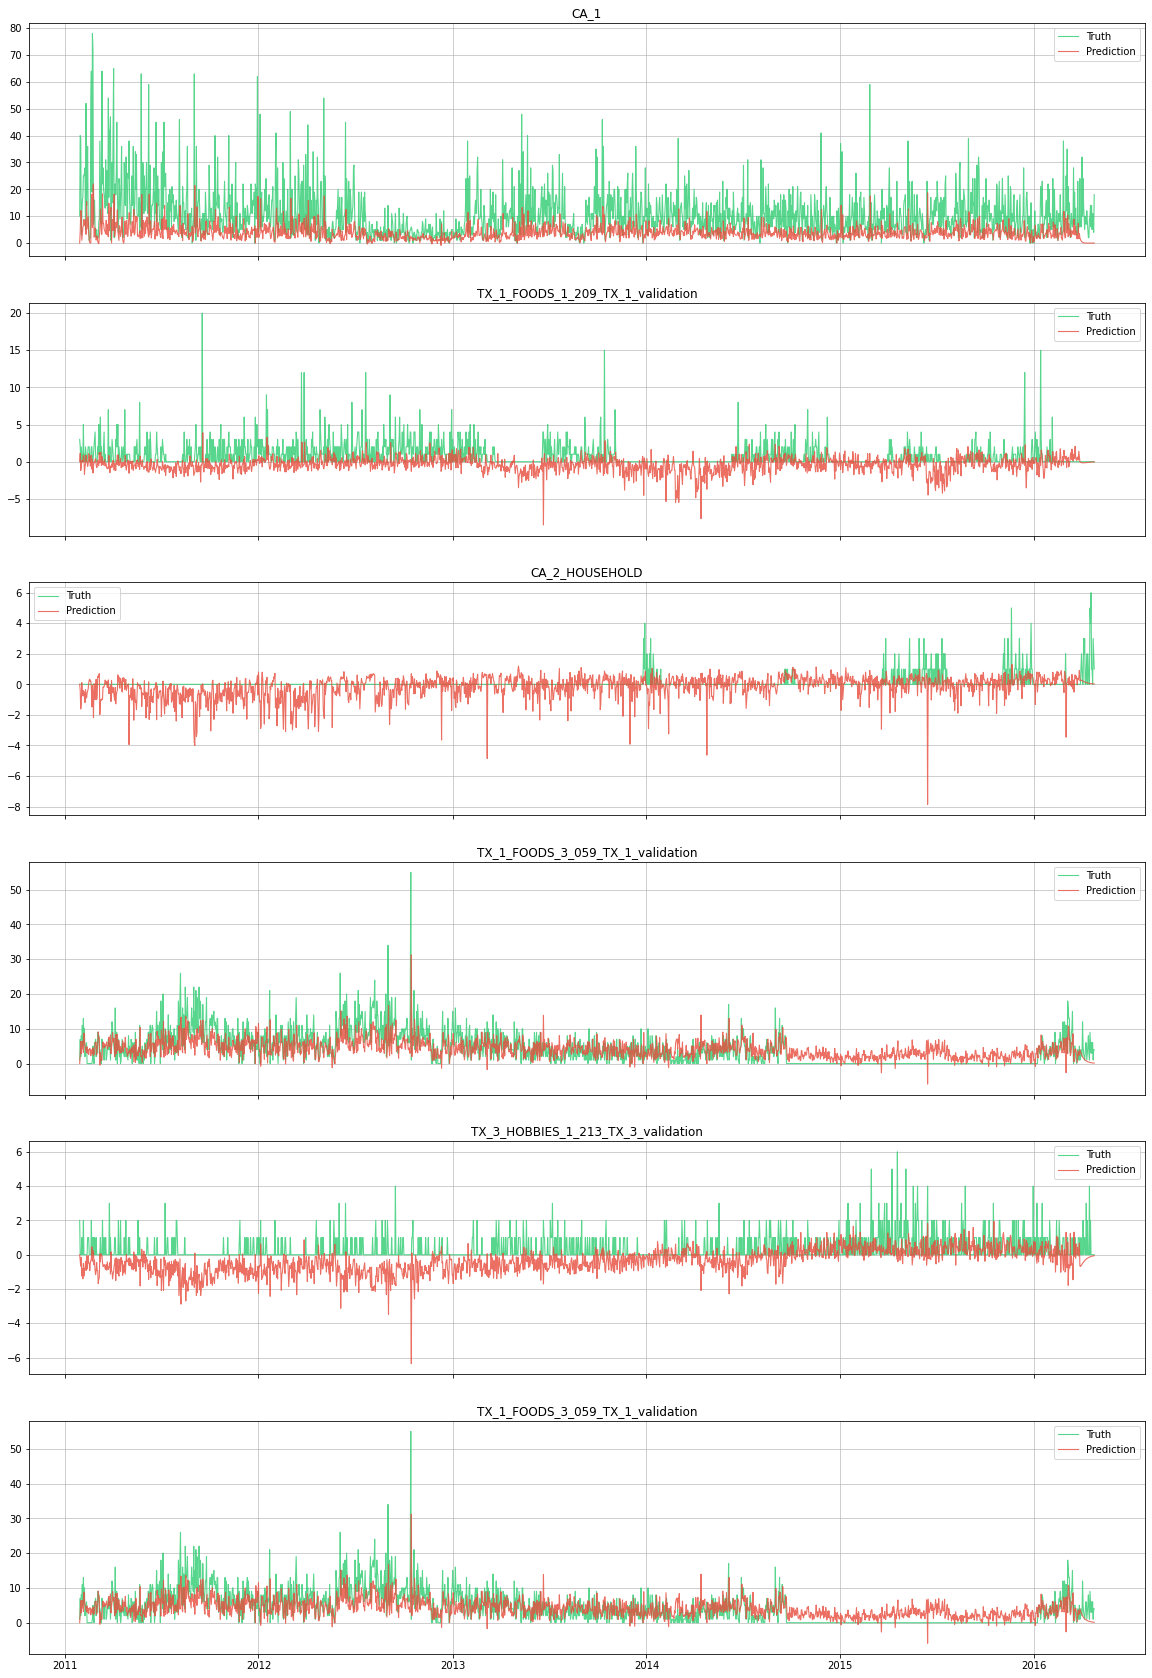

In [25]:
keys = [ 
        'CA_1',
        'TX_1_FOODS_1_209_TX_1_validation', 
        'CA_2_HOUSEHOLD',
        'TX_1_FOODS_3_059_TX_1_validation', 
        'TX_3_HOBBIES_1_213_TX_3_validation',
        'TX_1_FOODS_3_059_TX_1_validation',
       ]

plot(keys, preds, dfSelected)

# Saves 

In [26]:
path = 'result/'
method = '_sarimax'
ols = '_OLS_'
dataFrame = data_set.train_set
samples = data_set.sampleSize

saveDataset(path, dataFrame, method, ols, samples=samples)
saveModel(path, model, method, ols, samples=samples)

## Restore model

In [27]:
pathModel = 'result/model_sarimax_OLS_502021-12-0009-18-10-08.pkl'
modelRestore = loadModel(pathModel)